# Convolutional Neural Network for Sentence Classification:

###### Yassin Bahid

###### Abstract:
In the pursuit of a better text classification model, we choose to construct a sentence level neural network. We use Cornel's movie review database and fasttext vectorized word dictionary to vectorize the dataset. We train 3 different models using different embeding layers. 



In [18]:
from torchtext import data
from torchtext.vocab import Vectors
import spacy
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import nltk
# nltk.download('all')
from nltk.tokenize import word_tokenize
from collections import defaultdict
from tqdm import tqdm_notebook
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import time
import os
from pathlib import Path
import sys
import matplotlib.pyplot as plt


## 1 - Model Architecture:

We use Yoon Kim architechture presented in their paper "Convolutional Neural Networks for Sentence Classification". The model takes vectorized sentences and feeds them to a neural network before outputing a label. 
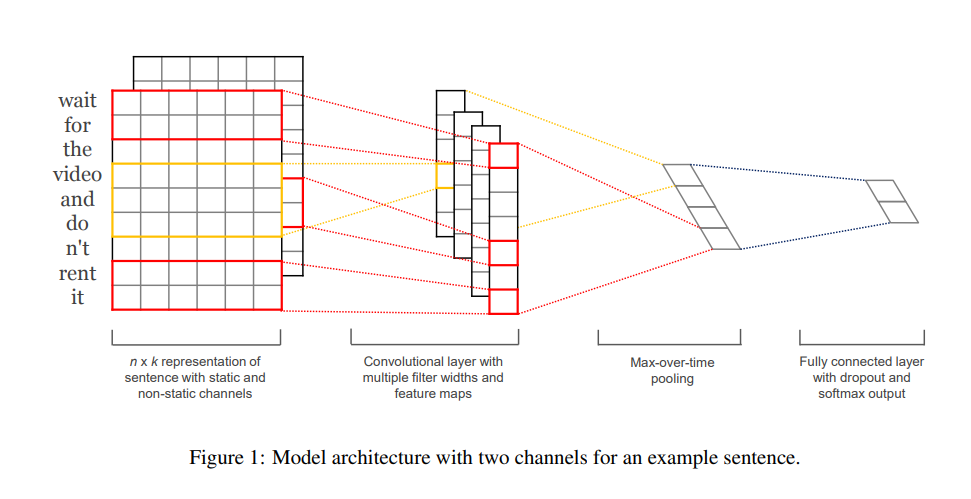

In particular we choose the followinng architechture:

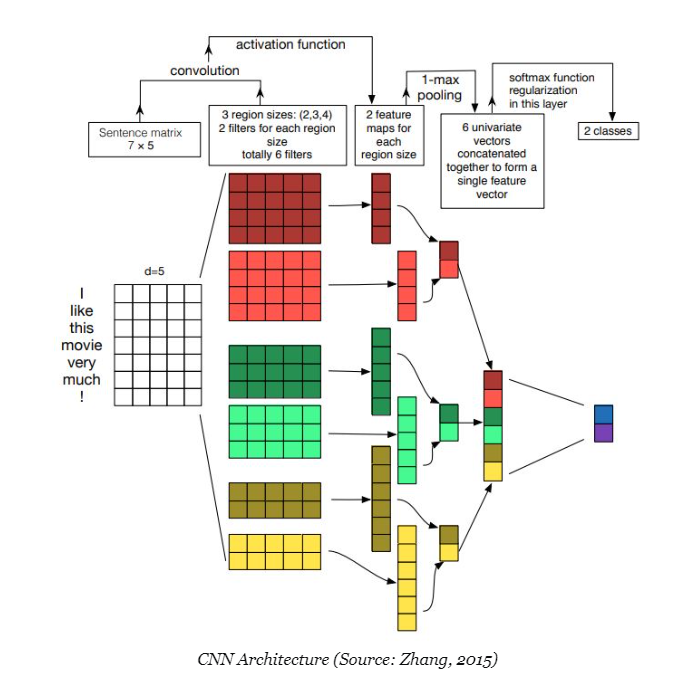

We use the same Adelta loss funtion presented in  the paper.
We shall compare different itterations of the CNN above. First, a similar model to kim's where the embedding layer is randomly generated. The second, has a static embedding layer during training. The last, optimizes the embeding layer while training. The code is detailed below.
.

## 2 - Results:
As seen in the plots below, the runtime stays relatively fast for all 3 models. However, the static model stays the fastest as the embeding layer is not optimised. The non static model performs the best, reaching a 88.5% accuracy, followed with the static model with 85.5%, and finally the random model at 78.5%. The non static model seems to converge to its maximum faster than the two other models. These models are better than the bag of words model. However, there are models than can outperform these architechtures. In future work, we shall explore models such as LSTM and transformers.

In [19]:
rand_acc = [50.50, 66.00, 51.00, 60.50, 64.00, 73.50, 69.00, 72.50, 71.00, 75.50, 75.50, 74.00, 73.50, 74.00, 75.50, 75.00, 69.00, 78.00, 78.00, 78.50]
rand_total_time = 56.7
rand_final_acc = 78.5
stat_acc = [58.00, 74.00, 76.00, 78.50, 79.50, 75.50, 83.50, 82.00, 83.00, 84.50, 81.00, 85.50, 81.00, 81.00, 84.50, 85.00, 84.00, 82.50, 84.00, 83.50]
stat_total_time = 32.22
stat_final_acc =  85.50
nonstat_acc = [54.00, 63.00, 76.50, 76.00, 69.50, 75.50, 77.50, 78.50, 79.00, 83.00, 85.00, 85.50, 86.00, 86.00, 85.50, 85.50, 85.50, 86.00, 86.00, 86.50]
nonstat_total_time = 53.83
nonstat_final_acc = 86.50

training_times = [rand_total_time, stat_total_time, nonstat_total_time]
accuracies = [rand_final_acc, stat_final_acc, nonstat_final_acc]
y_pos = np.arange(len(training_times))
labels = ['Random Embeding', 'Static Embeding', 'Non Static Embeding']

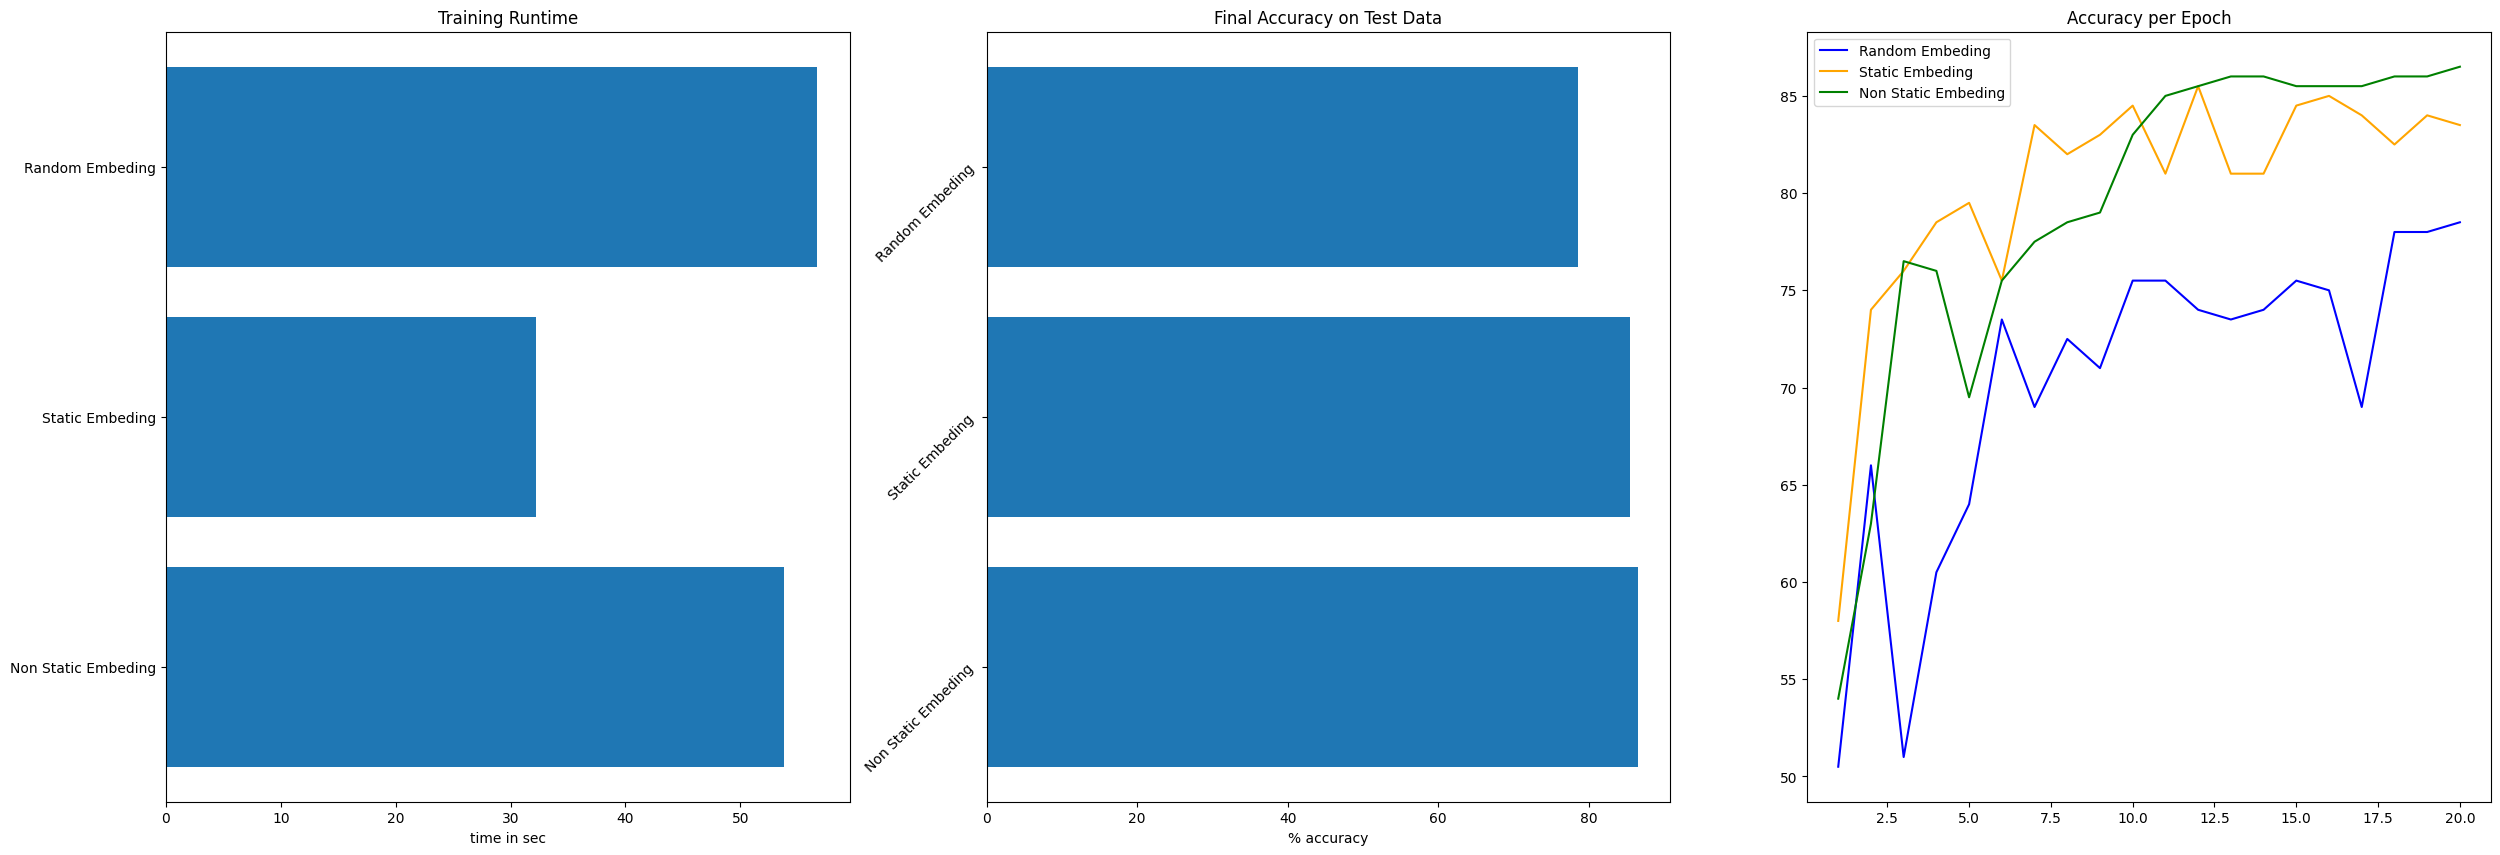

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

axes[0].barh(y_pos, training_times, align='center')
axes[0].set_yticks(y_pos, labels=labels)
axes[0].invert_yaxis()  # labels read top-to-bottom
axes[0].set_xlabel('time in sec')
axes[0].set_title('Training Runtime')






axes[1].barh(y_pos, accuracies, align='center')
axes[1].set_yticks(y_pos, labels=labels, rotation = 45)
axes[1].invert_yaxis()  # labels read top-to-bottom
axes[1].set_xlabel('% accuracy')
axes[1].set_title('Final Accuracy on Test Data')


epochs = [i+1 for i in range(20)] 
axes[2].plot(epochs, np.array(rand_acc), color = 'blue', label = 'Random Embeding' )
axes[2].plot(epochs, np.array(stat_acc), color = 'orange', label = 'Static Embeding' )
axes[2].plot(epochs, np.array(nonstat_acc), color = 'green', label = 'Non Static Embeding' )
axes[2].legend()
axes[2].set_title('Accuracy per Epoch')
plt.show()

## 3 - Data:

We use the Cornell movie review dataset found in: https://www.cs.cornell.edu/people/pabo/movie-review-data/. The data contains 2000 reviews equally devided into negative and positive reviews. We tokenize the data and vectorize it following the facebook fasttext word2idx corpus. We then divide the data into a train set consisting of 90% of the data and reserve 10% for validation.

In [2]:
def load_text(path):
    """Load text data, lowercase text and save to a list."""

    source_dir = Path(path)
    files = source_dir.iterdir()
    texts = []
    for file in files:
        with file.open('r') as fl :
            txt  = fl.read().replace('\n', '')
            texts.append(txt.lower().strip())

    return texts

# Load files
neg_text = load_text('data/neg/')
pos_text = load_text('data/pos/')

# Concatenate and label data
texts = np.array(neg_text + pos_text)
labels = np.array([0]*len(neg_text) + [1]*len(pos_text))

#### 3.1 - Tokenization of the dataset:

In [3]:
def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

#### 3.2 - Loading Vectors:

In [4]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [5]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, "fastText/crawl-300d-2M.vec")
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


C:\Users\yassin\AppData\Local\Temp\ipykernel_12688\1275949956.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

There are 39408 / 46464 pretrained vectors found.


#### 3.3 - Creating Train and Validation set and Dataloader:


In [6]:

## Creating Data Loader:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
                                                                input_ids, 
                                                                labels, 
                                                                test_size=0.1, 
                                                                random_state=42)

def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

train_dataloader, val_dataloader = data_loader(train_inputs, 
                                               val_inputs, 
                                               train_labels, 
                                               val_labels, 
                                               batch_size=50)

## 4 - Sentence Level CNN implementation:

In [7]:
# config:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding: (vocab_size, embed_dim) Pretrained embeddings with
            freeze_embedding (bool): Set to False to fine-tune pretraiend vectors.
            vocab_size (int): Need to be specified when not pretrained word embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # embeddings from input_ids.
        x_embed = self.embedding(input_ids).float()

        # Permute x_embed to match nn.Conv1d.
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU\
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits
        logits = self.fc(self.dropout(x_fc))

        return logits

#### 4.1 - Optimizer:

In [8]:
def initialize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [9]:
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""

    best_accuracy = 0

    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):

        #               Training

        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):

            b_input_ids, b_labels = tuple(t.to(device) for t in batch)
            b_labels = b_labels.type(torch.LongTensor) 
            b_labels = b_labels.to(device)
            model.zero_grad()

            logits = model(b_input_ids)

            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            loss.backward()

            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)

        #               Evaluation

        if val_dataloader is not None:

            val_loss, val_accuracy = evaluate(model, val_dataloader)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """

    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:

        b_input_ids, b_labels = tuple(t.to(device) for t in batch)
        # b_labels = b_labels.type(torch.LongTensor) 
        b_labels = b_labels.to(device).long()
        with torch.no_grad():
            logits = model(b_input_ids)
            # logitslong = logits.type(torch.LongTensor) 
            # logitslong = logits.to(device)
            
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()
        

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        # print('acc',accuracy)
        # print('item', accuracy.item())
        val_accuracy.append(accuracy.item())
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

#### 4.2 - Random char-CNN:

In [10]:
set_seed(42)
device = torch.device("cuda")
cnn_rand, optimizer = initialize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.718744   |  0.698950  |   50.50   |   12.95  
   2    |   0.674250   |  0.665016  |   66.00   |   2.30   
   3    |   0.633747   |  0.681120  |   51.00   |   2.28   
   4    |   0.593085   |  0.648240  |   60.50   |   2.30   
   5    |   0.563412   |  0.625635  |   64.00   |   2.29   
   6    |   0.544737   |  0.593221  |   73.50   |   2.30   
   7    |   0.495735   |  0.588555  |   69.00   |   2.31   
   8    |   0.459546   |  0.565979  |   72.50   |   2.30   
   9    |   0.427070   |  0.548847  |   71.00   |   2.30   
  10    |   0.397991   |  0.536453  |   75.50   |   2.30   
  11    |   0.370031   |  0.534870  |   75.50   |   2.30   
  12    |   0.351418   |  0.520514  |   74.00   |   2.31   
  13    |   0.319439   |  0.536729  |   73.50   |   2.32   
  14    |   0.284138   |  0.530742  |   74.00   |   2.30   
  15    |   0.268789

#### 4.3 - Static CNN:

In [13]:
cnn_static, optimizer = initialize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.25,
                                        dropout=0.5)
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.702673   |  0.682970  |   58.00   |   1.76   
   2    |   0.666214   |  0.660588  |   74.00   |   1.58   
   3    |   0.629154   |  0.628182  |   76.00   |   1.60   
   4    |   0.569956   |  0.588336  |   78.50   |   1.59   
   5    |   0.521203   |  0.543595  |   79.50   |   1.59   
   6    |   0.455106   |  0.515784  |   75.50   |   1.59   
   7    |   0.395540   |  0.472595  |   83.50   |   1.60   
   8    |   0.349089   |  0.447346  |   82.00   |   1.59   
   9    |   0.299763   |  0.420612  |   83.00   |   1.60   
  10    |   0.258739   |  0.408573  |   84.50   |   1.59   
  11    |   0.214183   |  0.393277  |   81.00   |   1.59   
  12    |   0.178940   |  0.382738  |   85.50   |   1.59   
  13    |   0.141332   |  0.369497  |   81.00   |   1.61   
  14    |   0.121001   |  0.367027  |   81.00   |   1.59   
  15    |   0.105165

#### 4.4 - Non Static CNN:

In [15]:
set_seed(42)
cnn_non_static, optimizer = initialize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.701336   |  0.681519  |   54.00   |   3.04   
   2    |   0.662459   |  0.663675  |   63.00   |   2.65   
   3    |   0.638332   |  0.635757  |   76.50   |   2.66   
   4    |   0.586625   |  0.600374  |   76.00   |   2.65   
   5    |   0.525399   |  0.572852  |   69.50   |   2.67   
   6    |   0.474250   |  0.545834  |   75.50   |   2.67   
   7    |   0.427791   |  0.516749  |   77.50   |   2.67   
   8    |   0.359054   |  0.457743  |   78.50   |   2.67   
   9    |   0.308443   |  0.445507  |   79.00   |   2.67   
  10    |   0.262058   |  0.409633  |   83.00   |   2.68   
  11    |   0.220344   |  0.396695  |   85.00   |   2.68   
  12    |   0.183244   |  0.370587  |   85.50   |   2.66   
  13    |   0.155190   |  0.366885  |   86.00   |   2.67   
  14    |   0.132827   |  0.354532  |   86.00   |   2.70   
  15    |   0.105405